# Import Libraries

In [108]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import numpy as np
import pandas as pd

import tqdm
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.backend import ctc_batch_cost, ctc_decode
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

In [109]:
print("TensorFlow Version:",tf.__version__)

TensorFlow Version: 2.16.1


# Load Data

In [110]:
root_dir = "./samples"

In [111]:
image_paths = []
labels = []

for file in tqdm.tqdm(os.listdir(root_dir)):
    filepath = os.path.join(root_dir, file)
    label = filepath.split("/")[-1].split(".")[0]

    image_paths.append(filepath)
    labels.append(label)

100%|██████████| 1187/1187 [00:00<00:00, 1029495.21it/s]


In [112]:
images_df = pd.DataFrame({"image_path": image_paths, "label": labels})
images_df.head()

,image_path,label
0,./samples/259276.png,259276
1,./samples/312075.png,312075
2,./samples/989493.png,989493
3,./samples/231690.png,231690
4,./samples/635167.png,635167


In [113]:
characters = set(char for label in labels for char in label)
print("Characters:\n", characters)

Characters:
 {'7', '5', '0', '3', '1', '8', '9', '2', '6', '4'}


# Preprocess

In [114]:
char_to_num = layers.StringLookup(
    vocabulary = list(characters),
    num_oov_indices = 0,
    mask_token = None
)

In [115]:
pd.DataFrame({"char": char_to_num.get_vocabulary(),
              "num": np.arange(1, len(char_to_num.get_vocabulary())+1)})

,char,num
0,7,1
1,5,2
2,0,3
3,3,4
4,1,5
5,8,6
6,9,7
7,2,8
8,6,9
9,4,10


In [116]:
num_to_char = layers.StringLookup(
    vocabulary = char_to_num.get_vocabulary(),
    mask_token = None,
    invert = True
)

In [117]:
def encode_single_sample(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    # image = tf.image.resize(image, [50, 200])
    image = tf.transpose(image, perm=[1, 0, 2])
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    return image, label

In [118]:
def process_dataset(X, y):
    images = []
    labels = []
    for img_path, label in zip(X, y):
        img, lbl = encode_single_sample(img_path, label)
        images.append(img.numpy())
        labels.append(lbl.numpy())
    return np.array(images), np.array(labels)

In [119]:
X_train, X_test, y_train, y_test = train_test_split(np.array(image_paths), 
                                                    np.array(labels), 
                                                    test_size=0.10, random_state=42)

In [120]:
X_train_processed, y_train_processed = process_dataset(X_train, y_train)
X_test_processed, y_test_processed = process_dataset(X_test, y_test)

In [121]:
X_train_input = {"Input": X_train_processed, "Label": y_train_processed}
X_test_input = {"Input": X_test_processed, "Label": y_test_processed}

# Visualization

In [122]:
def visualize_df(df: pd.DataFrame):
    fig, axes = plt.subplots(4, 4, figsize=(10, 5))

    for i, ax in enumerate(axes.ravel()):
        if i < len(df):
            a = np.random.randint(1, len(df), 1)[0]
            img_path = df.loc[a][['image_path']].values[0]
            label = df.loc[a][["label"]].values[0]
            
            image = Image.open(img_path).convert('RGB')
            
            ax.imshow(image)
            ax.set_title(f"CAPTCHA: {label}")
            ax.axis('off')
            
        else:
            ax.axis('off')
            
    plt.tight_layout()
    plt.show()

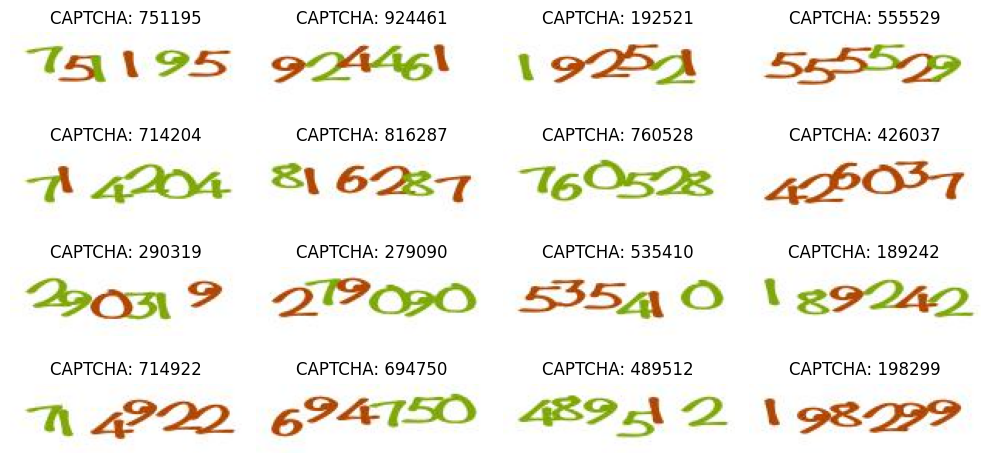

In [123]:
visualize_df(images_df)

# Model

In [124]:
class CTCLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_length = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_length, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_length, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred

In [125]:
input_layer = layers.Input(shape=(150, 45, 3), name="Input", dtype="float32")
label_layer = layers.Input(shape=(None,), name="Label", dtype="float32")

conv2_1 = layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(input_layer)
max2_1 = layers.MaxPooling2D(strides=(2, 2))(conv2_1)

conv2_2 = layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(max2_1)
max2_2 = layers.MaxPooling2D(strides=(2, 2))(conv2_2)

reshape_layer = layers.Reshape(target_shape=((150 // 4), (45 // 4) * 64))(max2_2)
dense_1 = layers.Dense(units=32, activation="relu")(reshape_layer)
drop_1 = layers.Dropout((0.2))(dense_1)

bilstm_1 = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(drop_1)
bilstm_2 = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(bilstm_1)

output_layer = layers.Dense(len(characters) + 1, activation="softmax", name="Output")(bilstm_2)

output = CTCLayer(name="ctc_loss")(label_layer, output_layer)

model = models.Model(inputs=[input_layer, label_layer], outputs=output, name="OCR")

In [126]:
model.compile(optimizer=optimizers.Adam())

In [127]:
model.summary()

Model: "OCR"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)  │ (None, 150, 45,   │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 150, 45,   │        896 │ Input[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 75, 22,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 75, 22,    │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 37, 11,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 37, 704)   │          0 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 37, 32)    │     22,560 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 37, 32)    │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 37, 256)   │    164,864 │ dropout_2[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 37, 128)   │    164,352 │ bidirectional_4[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output (Dense)      │ (None, 37, 11)    │      1,419 │ bidirectional_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_loss (CTCLayer) │ (None, 37, 11)    │          0 │ Label[0][0],      │
│                     │                   │            │ Output[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 372,587 (1.42 MB)

 Trainable params: 372,587 (1.42 MB)

 Non-trainable params: 0 (0.00 B)

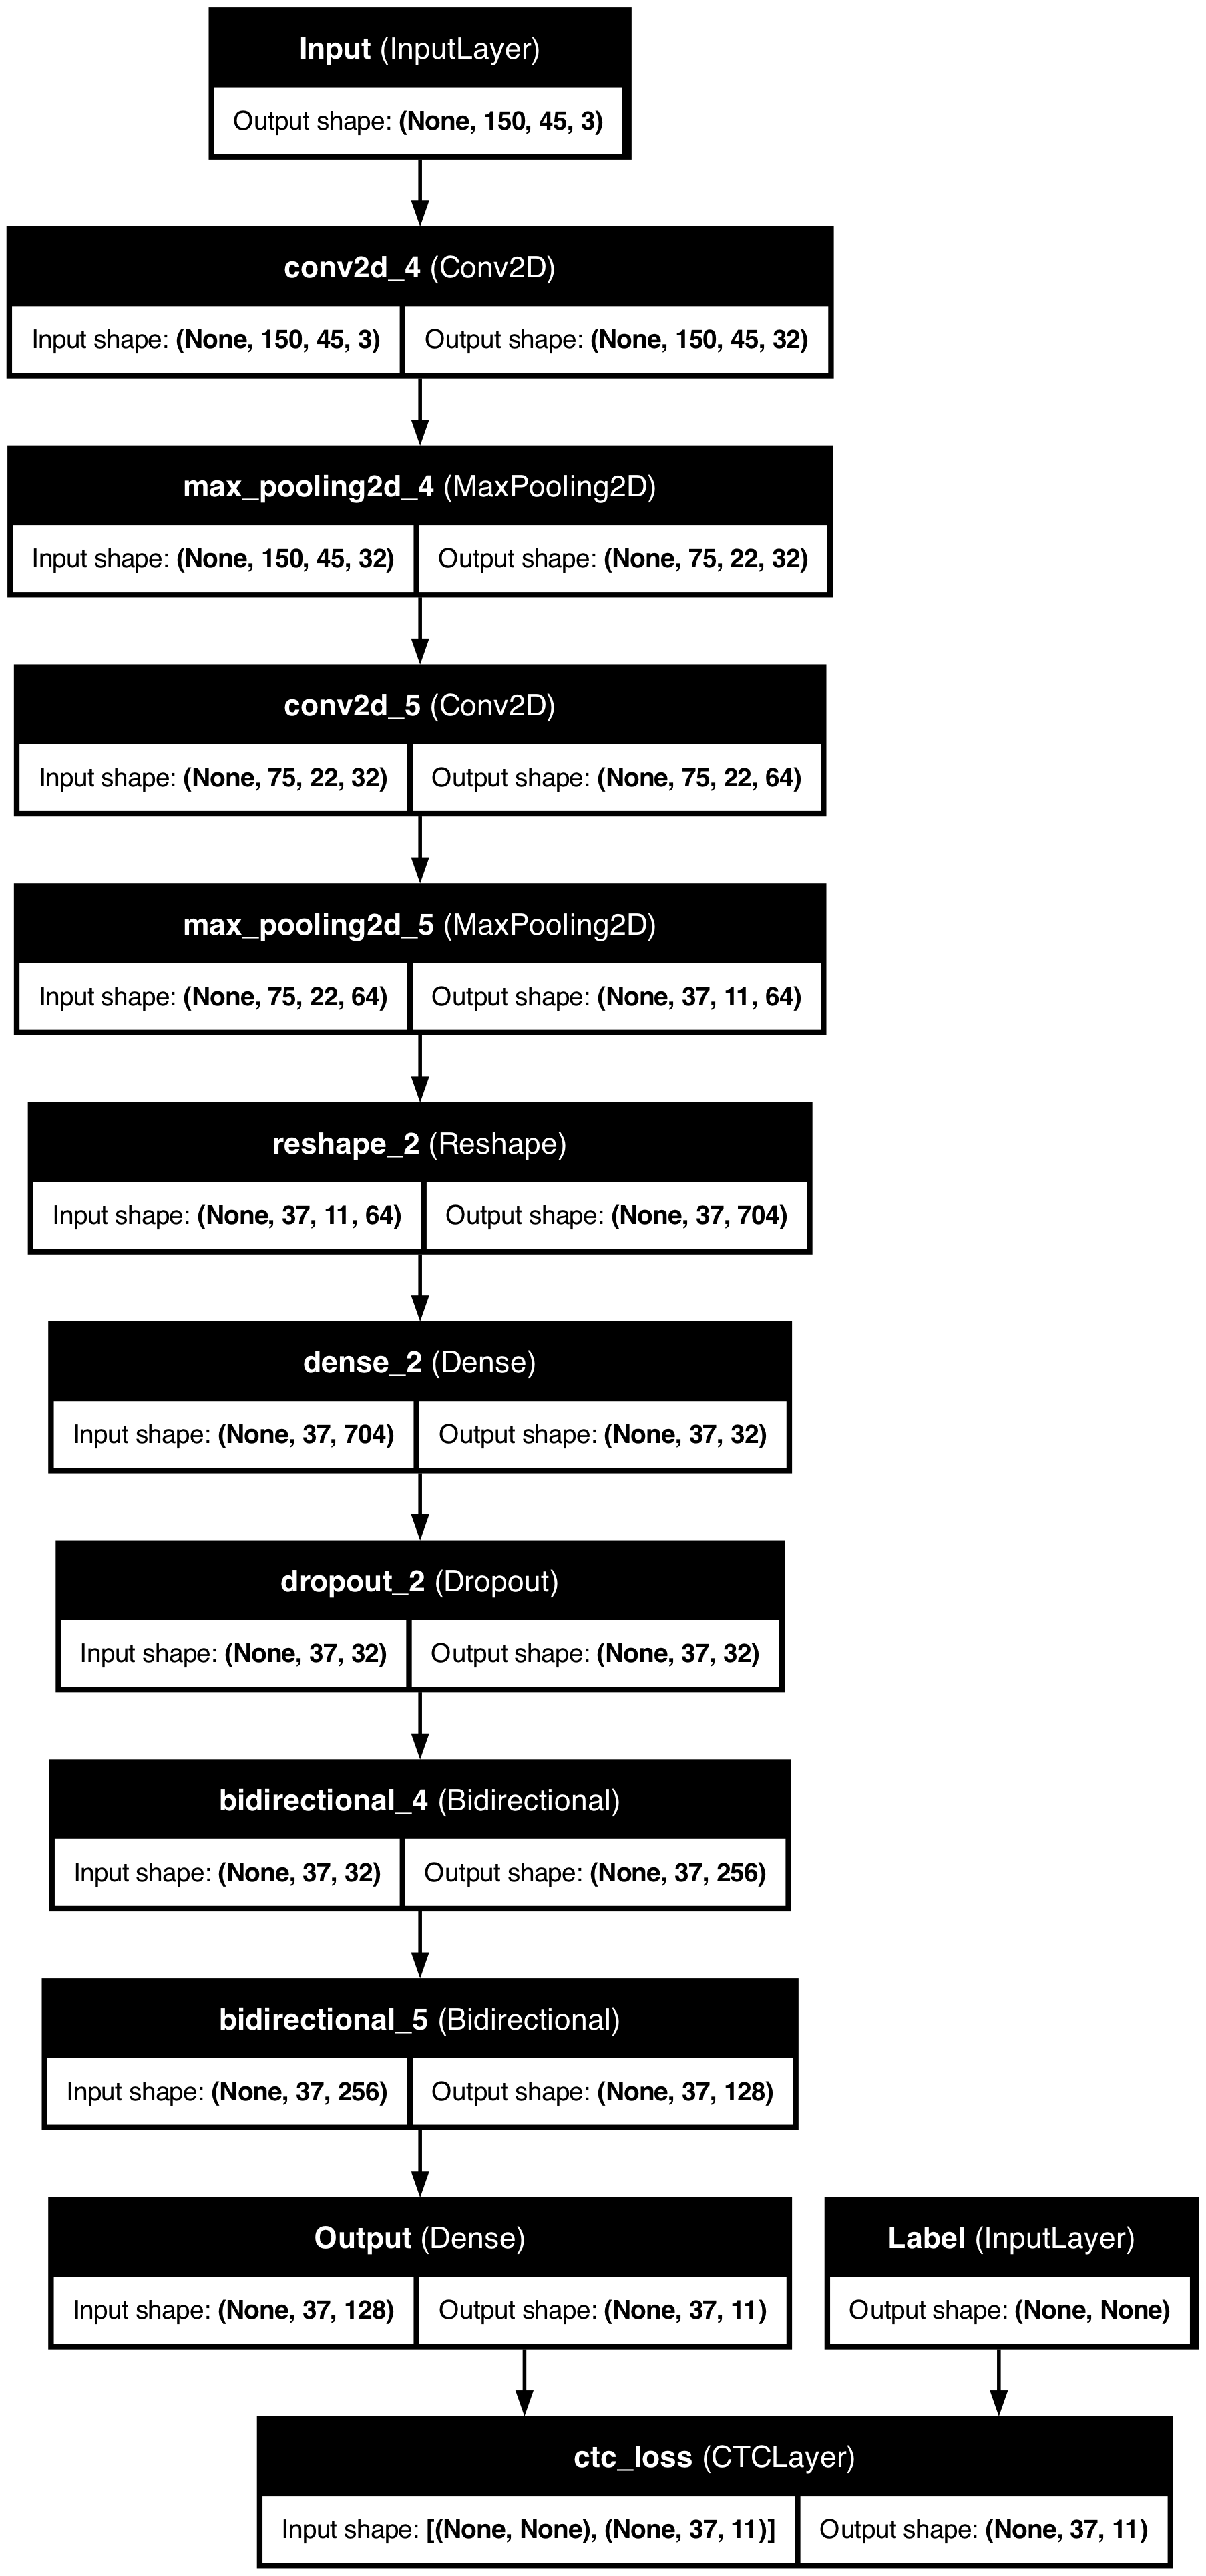

In [128]:
# plot_model(model, show_layer_names=True, show_shapes=True, expand_nested=True)

# Train

In [129]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5)

In [140]:
import numpy as np
import tensorflow as tf
from PIL import Image

from utils.CTCLayer import CTCLayer

# MODEL_PATH = "captcha_mpets.keras"
MODEL_PATH = "captcha_mpets.keras"
model = tf.keras.models.load_model(MODEL_PATH, custom_objects={'CTCLayer': CTCLayer})

In [143]:
history = model.fit(
    X_train_input,
    y_train_processed,
    validation_data=(X_test_input, y_test_processed),
    epochs=10,
    batch_size=32,
    # callbacks=[early_stopping]
)
model.save("captcha_mpets.keras")

Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - loss: 4.8080 - val_loss: 1.5702
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - loss: 3.5859 - val_loss: 1.9689
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - loss: 3.9665 - val_loss: 1.2525
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - loss: 3.2767 - val_loss: 2.2488
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - loss: 4.8348 - val_loss: 2.3030
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - loss: 3.1480 - val_loss: 2.0272
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - loss: 3.5988 - val_loss: 2.5716
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - loss: 3.1144 - val_loss: 1.4130
Epoch 9/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - loss: 2.7826 - val_loss: 1.6658
Epoch 10/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - loss: 4.0755 - val_loss: 2.4205


# Results

In [132]:
# from keras import models
# model = models.load_model("captcha_mpets.keras", custom_objects={"CTCLayer": CTCLayer})

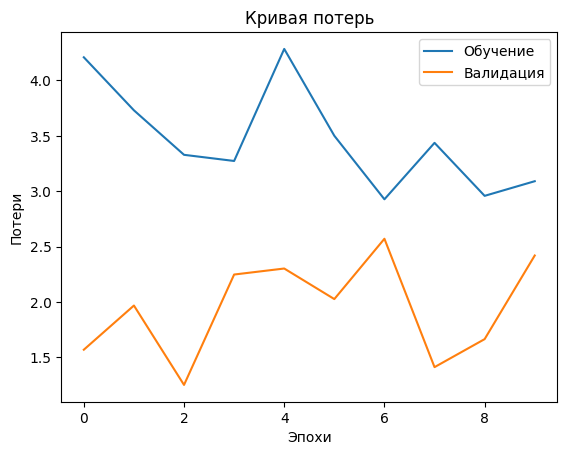

In [144]:
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("Эпохи")
plt.ylabel("Потери")
plt.legend(["Обучение", "Валидация"])
plt.title("Кривая потерь")
plt.show()
# Test

In [134]:
preds = model.predict(X_test_input)
input_length = np.ones(preds.shape[0]) * preds.shape[1]
results = ctc_decode(preds, input_length=input_length, greedy=True)[0][0][:, :6]
pred_texts = []
for result in results:
    res = tf.strings.reduce_join(num_to_char(result+1)).numpy().decode("utf-8")
    pred_texts.append(res)


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step WARNING:tensorflow:6 out of the last 10 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x36af18820> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step


In [135]:
pred_df = pd.DataFrame({
    "Путь до файла": X_test,
    "Ожидалось": y_test,
    "Результат": pred_texts,
    "Совпадение": [1 if y_test[i] == pred_texts[i] else 0 for i in range(len(y_test))]
})
print(X_test)

['./samples/806074.png' './samples/475256.png' './samples/925575.png'
 './samples/254221.png' './samples/426745.png' './samples/453767.png'
 './samples/125656.png' './samples/853368.png' './samples/968790.png'
 './samples/514198.png' './samples/770158.png' './samples/308432.png'
 './samples/429303.png' './samples/528441.png' './samples/954620.png'
 './samples/507553.png' './samples/427722.png' './samples/579640.png'
 './samples/600763.png' './samples/429212.png' './samples/431577.png'
 './samples/805056.png' './samples/739916.png' './samples/400771.png'
 './samples/699178.png' './samples/161929.png' './samples/839440.png'
 './samples/250002.png' './samples/193847.png' './samples/342230.png'
 './samples/650952.png' './samples/621517.png' './samples/493229.png'
 './samples/260287.png' './samples/569469.png' './samples/337183.png'
 './samples/849431.png' './samples/333800.png' './samples/598612.png'
 './samples/616442.png' './samples/507561.png' './samples/878954.png'
 './samples/243146.p

In [136]:
pred_df.head(1000)

,Путь до файла,Ожидалось,Результат,Совпадение
0,./samples/806074.png,806074,806074,1
1,./samples/475256.png,475256,475256,1
2,./samples/925575.png,925575,925575,1
3,./samples/254221.png,254221,254221,1
4,./samples/426745.png,426745,426745,1
...,...,...,...,...
114,./samples/359189.png,359189,359189,1
115,./samples/120136.png,120136,120136,1
116,./samples/585822.png,585822,585822,1
117,./samples/586133.png,586133,586133,1


In [137]:
pred_df.to_excel("preds.xlsx")

In [138]:
def visualize_predictions(df: pd.DataFrame):
    fig, axes = plt.subplots(4, 4, figsize=(10, 5))

    for i, ax in enumerate(axes.ravel()):
        if i < len(df):
            a = np.random.randint(1, len(df), 1)[0]
            img_path = df.loc[a][['image_path']].values[0]
            label = df.loc[a][["label"]].values[0]
            pred = df.loc[a][["pred"]].values[0]
            
            image = Image.open(img_path).convert('RGB')
            
            ax.imshow(image)
            ax.set_title(f"Ожидалось: {label}\nРезультат: {pred}")
            ax.axis('off')
            
        else:
            ax.axis('off')
            
    plt.tight_layout()
    plt.show()

KeyError: "None of [Index(['image_path'], dtype='object')] are in the [index]"

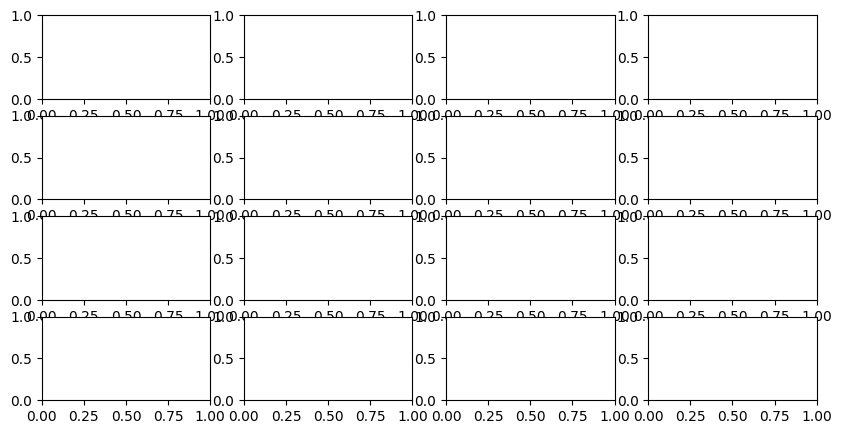

In [139]:
visualize_predictions(pred_df)